<a href="https://colab.research.google.com/github/gvkannan-explore/mednist_trials/blob/main/MedNIST_Monai_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Image Classification with the MedNIST + HAM10k Dataset

In [ ]:
!wget -q https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz

In [ ]:
import os
from pathlib import PosixPath, Path

In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import classification_report
from typing import List, Dict, Any
from tqdm.notebook import tqdm

## Monai related
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks import nets as monai_nets
from monai import transforms as T
from monai.data import CacheDataset, Dataset, DataLoader
from monai.utils import set_determinism

In [ ]:
dataset_dir = Path(
    "/content/drive/MyDrive/datasets/MedNIST.tar.gz")

In [ ]:
## Unzip the current directory:
import tarfile
datafile = tarfile.open(dataset_dir)
datafile.extractall()
datafile.close()

In [ ]:
## Installing relevant libraries
!pip3 install -q monai nibabel tqdm itk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 57.0 MB/s eta 0:00:00


In [ ]:
## Hyperparam:
hparams_dict = {
    "finetune_frac": 0.1,
    "test_frac": 0.1,
    "train_batchsize": 1024,
    "ftune_batchsize": 1024,
    "num_workers": 2,
    "device": "cpu",
    "spatial_dims": 2,
    "in_channels": 1,
    "out_channels": 5,
    "loss": "CrossEntropyLoss",
    "optimizer": "AdamW",
    "epochs": 4,
    "val_interval": 1,
    "lr": 1e-5,
}

## TO DO:
## 1. Add Integration with W&B
## 2. Update scripts to use pytorch.
## 3. Integrate cfg_nn to allow configurable networks

### Simple Data-Processing

In [ ]:
data_dir = Path("/content/MedNIST/")
class_names = [
    fname for fname in os.listdir(data_dir) if (data_dir / fname).is_dir()]
class_names ## Classes: Hand, CXR, BreastMRI, HeadCT, AbdomenCT, ChestCT


['Hand', 'CXR', 'BreastMRI', 'HeadCT', 'AbdomenCT', 'ChestCT']

In [ ]:
data_dir = Path("/content/MedNIST/")
class_names = [fname for fname in os.listdir(data_dir) if (data_dir / fname).is_dir()]
num_classes = len(class_names)
image_dict = {
    class_name: [
        data_dir / class_name / x for x in os.listdir(data_dir / class_name)]
    for class_name in class_names

}

image_fdirs, image_labels = [],[]
for idx, class_name in enumerate(class_names):
  image_fdirs.extend(image_dict[class_name])
  image_labels.extend([idx] * len(image_dict[class_name]))

num_total = len(image_labels)
image_width, image_height = Image.open(image_fdirs[0]).size

## Basic Stats:
print(f"Total Image Counts: {num_total}")
print(f"Image dimension: width: {image_width} x height: {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: ")
for class_name, class_list in image_dict.items():
  print(f"{class_name}: {len(class_list)}")

Total Image Counts: 58954
Image dimension: width: 64 x height: 64
Label names: ['Hand', 'CXR', 'BreastMRI', 'HeadCT', 'AbdomenCT', 'ChestCT']
Label counts: 
Hand: 10000
CXR: 10000
BreastMRI: 8954
HeadCT: 10000
AbdomenCT: 10000
ChestCT: 10000


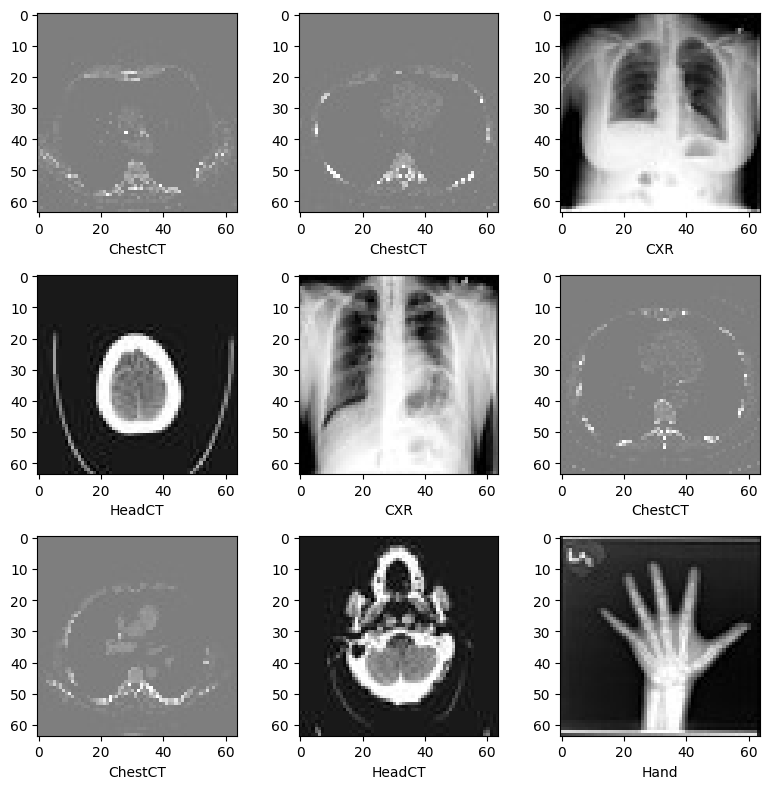

In [ ]:
## Visualize randomly picked samples:
plt.subplots(3, 3, figsize=(8, 8))

for i, k in enumerate(np.random.randint(num_total, size=9)):
  img = Image.open(image_fdirs[k])
  arr = np.array(img)
  plt.subplot(3, 3, i+1)
  plt.xlabel(class_names[image_labels[k]])
  plt.imshow(arr, cmap="gray", vmin=0, vmax=255) ## Restricting to vrange: (0, 255)
plt.tight_layout()
plt.show()


## Prepare Train-Finetune-Test Splits

In [ ]:
finetune_frac, test_frac = hparams_dict['finetune_frac'], hparams_dict['test_frac']
ixs = [idx for idx in range(num_total)]
np.random.shuffle(ixs)
train_ixs = ixs[:int(num_total*(1-(finetune_frac+test_frac)))]
ftune_ixs = ixs[int(num_total*(1-(finetune_frac+test_frac))):int(num_total*(1-(test_frac)))]
test_ixs = ixs[int(num_total*(1-(test_frac))):]

trainX = [image_fdirs[idx] for idx in train_ixs]
trainY = [image_labels[idx] for idx in train_ixs]

ftuneX = [image_fdirs[idx] for idx in ftune_ixs]
ftuneY = [image_labels[idx] for idx in ftune_ixs]

testX = [image_fdirs[idx] for idx in test_ixs]
testY = [image_labels[idx] for idx in test_ixs]

print(
    "Training count =",len(trainX),"Validation count =", len(ftuneX), "Test count =",len(testX))

Training count = 47163 Validation count = 5895 Test count = 5896


## Data Module Dev

In [ ]:
train_transforms = T.Compose([
    T.LoadImage(image_only=True),
    T.EnsureChannelFirst(), ## Adds Channel Index!
    T.ScaleIntensity(), ## Scale between 0 to 1
    T.RandRotate(range_x=15, prob=0.5, keep_size=True),
    T.RandFlip(spatial_axis=0, prob=0.5), ## Assuming the shapes don't change!
    T.RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True), ## To not break the model
])


ftune_transforms = T.Compose([
    T.LoadImage(image_only=True),
    T.EnsureChannelFirst(),
    T.ScaleIntensity(),
    T.ToTensor(),
])

post_transform = T.Compose([
    T.Activations(softmax=True),
])
onehot = T.AsDiscrete(to_onehot=num_classes)

In [ ]:
class MedNIST_Dataset(torch.utils.data.Dataset):

  def __init__(
      self,
      image_fdirs: List,
      labels: List,
      transforms: Any):
    self.image_fdirs = image_fdirs
    self.labels = labels
    self.transforms = transforms

    def __len__(self):
      return len(self.image_fdirs)

    def __getitem__(self, index):
      return self.transforms(self.image_fdirs[index]), self.labels[index]


In [ ]:
## Create Datasets and Dataloaders:
train_ds = MedNIST_Dataset(
    image_fdirs=trainX,
    labels=trainY,
    transforms=train_transforms)
train_dl = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=hparams_dict['train_batchsize'],
    num_workers=hparams_dict['num_workers'],
)

ftune_ds = MedNIST_Dataset(
    image_fdirs=ftuneX,
    labels=ftuneY,
    transforms=ftune_transforms)
ftune_dl = torch.utils.data.DataLoader(
    dataset=ftune_ds,
    batch_size=hparams_dict['ftune_batchsize'],
    num_workers=hparams_dict['num_workers'],
)

test_ds = MedNIST_Dataset(
    image_fdirs=testX,
    labels=testY,
    transforms=ftune_transforms)
test_dl = torch.utils.data.DataLoader(
    dataset=test_ds,
    batch_size=hparams_dict['ftune_batchsize'],
    num_workers=hparams_dict['num_workers'],
)

## Define network & training configuration

In [ ]:
device = torch.device(hparams_dict['device'])
net = monai_nets.DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_classes,
) ## Smallest classification model in monai. Let's try ViT once this is done!
## Also rwhitman's models
net = torch.compile(net)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    params=net.parameters(),
    lr=hparams_dict['lr'])

In [ ]:
type(net)

monai.networks.nets.densenet.DenseNet121

In [ ]:
def train_fn(
    net: Any,
    optimizer: Any,
    hparams_dict: Dict,
    train_dl: torch.utils.data.DataLoader,
    loss_fn: Any,
    device: str = "cpu") -> Dict:
  """
  Template loss function!
  """
  log_dict = {
      "epoch_loss": [],
  } ## Allows tracking metrics as well.

  epoch_loss, step = 0, 0
  for epoch in tqdm(range(hparams_dict['epochs'])):
    net.train()
    for batch_data in tqdm(train_dl):
      step += 1
      inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
    epoch_loss /= step
    log_dict['epoch_loss'].append(epoch_loss)

  return log_dict

# @torch.no_grad
# def ftune_fn(
#     net: Any,
#     optimizer: Any,
#     hparams_dict: Dict,
#     test_dl: torch.utils.data.DataLoader,
#     metrics_list: List,
#     loss_fn: Any,
#     device: str = "cpu") -> Dict:


